# General Stress-Thickness Fitting: Cr, V, W (BCC Refractory Metals)

This notebook demonstrates the general fitting workflow for stress-thickness curves
of BCC refractory metals. In general mode, grain size parameters (SigmaC, K0, alpha1,
L0, GrainSize_200) are per-dataset process parameters, while material-intrinsic
parameters (Sigma0, BetaD, Ea, Mfda, Di, A0, B0, l0) are shared across datasets
of the same material.

**Materials:** Cr, V, W  
**Data source:** Su (unpublished)

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

import torch
import torch.nn as nn

%matplotlib inline

# Add repo root to path
REPO_ROOT = Path('..').resolve().parent
sys.path.insert(0, str(REPO_ROOT))
from kmorfs import load_from_database, GeneralSTFModel

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.7.1+cpu
CUDA available: False


In [2]:
# ===== Configuration =====
MATERIALS = ["Cr", "V", "W"]
DATA_SOURCES = ["Su"]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
SOURCE_CSV = REPO_ROOT / "data" / "source.csv"
EXPERIMENTS_CSV = REPO_ROOT / "data" / "all_experiments.csv"

# Default initial guesses per material
MATERIAL_DEFAULTS = {
    "Cr": {
        "SigmaC": 0, "K0": 0, "alpha1": 0.02, "L0": 10, "GrainSize_200": 17.59,
        "Sigma0": 10, "BetaD": 0.1, "Ea": 0, "Mfda": 35.31, "Di": 0.5,
        "A0": -2, "B0": -6, "l0": 0.6,
    },
    "V": {
        "SigmaC": 0, "K0": 0, "alpha1": 0.02, "L0": 10, "GrainSize_200": 18.05,
        "Sigma0": 10, "BetaD": 0.001, "Ea": 0, "Mfda": 0.01, "Di": 0.02,
        "A0": -2, "B0": -9, "l0": 1.128,
    },
    "W": {
        "SigmaC": 0, "K0": 0, "alpha1": 0.02, "L0": 10, "GrainSize_200": 12.0,
        "Sigma0": 10, "BetaD": 0.02, "Ea": 0, "Mfda": 30, "Di": 0.4,
        "A0": -4, "B0": -10, "l0": 0.9,
    },
}
DEFAULT_PARAMS = {
    "SigmaC": 0, "K0": 0, "alpha1": 0.02, "L0": 10, "GrainSize_200": 15,
    "Sigma0": 10, "BetaD": 0.05, "Ea": 0, "Mfda": 20, "Di": 0.3,
    "A0": -3, "B0": -8, "l0": 0.8,
}

# Plot colors
COLORS = np.array([
    "#5B9BD5", "#A5D6A7", "#F1C40F", "#E74C3C",
    "#9B59B6", "#F39C12", "#1F77B4", "#BDC3C7"
])

try:
    matplotlib.rcParams['font.family'] = "Times New Roman"
except Exception:
    pass

print(f"Device: {DEVICE}")
print(f"Materials: {MATERIALS}")
print(f"Data sources: {DATA_SOURCES}")

Device: cpu
Materials: ['Cr', 'V', 'W']
Data sources: ['Su']


In [3]:
# Load experimental data from database
fit_data, process_condition, experiment_labels = load_from_database(
    source_path=SOURCE_CSV,
    experiments_path=EXPERIMENTS_CSV,
    materials=MATERIALS,
    data_sources=DATA_SOURCES,
)

print(f"Found {len(experiment_labels)} experiments:")
for label in experiment_labels:
    print(f"  {label}")
print(f"\nTotal data points: {len(fit_data)}")
print(f"\nProcess conditions:")
display(process_condition)

Found 20 experiments:
  Cr_Su_R0.08_T295_P0.27
  Cr_Su_R0.12_T295_P0.27
  Cr_Su_R0.24_T295_P0.27
  Cr_Su_R0.36_T295_P0.27
  Cr_Su_R0.48_T295_P0.27
  Cr_Su_R0.6_T295_P0.27
  V_Su_R0.02_T295_P0.27
  V_Su_R0.04_T295_P0.27
  V_Su_R0.06_T295_P0.27
  V_Su_R0.08_T295_P0.27
  V_Su_R0.1_T295_P0.27
  V_Su_R0.12_T295_P0.27
  V_Su_R0.16_T295_P0.27
  V_Su_R0.26_T295_P0.27
  V_Su_R0.36_T295_P0.27
  W_Su_R0.08_T295_P0.27
  W_Su_R0.12_T295_P0.27
  W_Su_R0.24_T295_P0.27
  W_Su_R0.36_T295_P0.27
  W_Su_R0.6_T295_P0.27

Total data points: 200

Process conditions:


,R,T,P,Melting_T
0,0.08,295,0.27,2180.0
1,0.12,295,0.27,2180.0
2,0.24,295,0.27,2180.0
3,0.36,295,0.27,2180.0
4,0.48,295,0.27,2180.0
5,0.60,295,0.27,2180.0
6,0.02,295,0.27,2183.0
7,0.04,295,0.27,2183.0
8,0.06,295,0.27,2183.0
9,0.08,295,0.27,2183.0


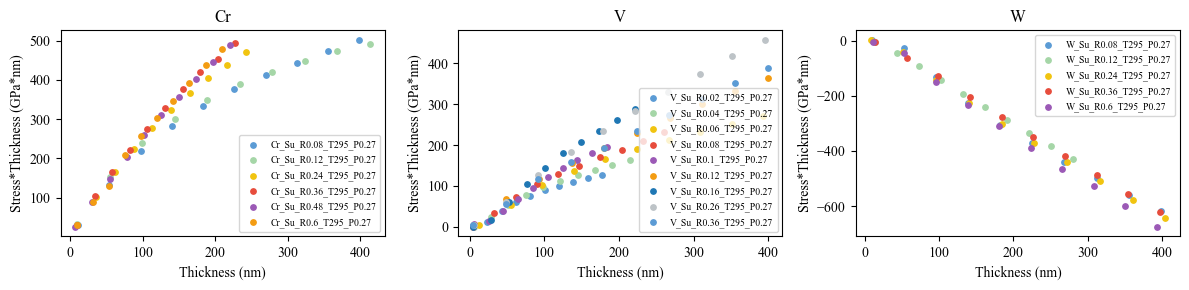

In [4]:
# Plot raw stress-thickness curves
melting_vals = process_condition['Melting_T'].unique()
material_names = [label.split('_')[0] for label in experiment_labels]
unique_materials = list(dict.fromkeys(material_names))

n_plots = len(melting_vals)
n_cols = min(4, n_plots)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
if n_plots == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes.reshape(1, -1)

for i, tm in enumerate(melting_vals):
    r, c = divmod(i, n_cols)
    ax = axes[r, c]
    matching = process_condition[process_condition['Melting_T'] == tm].index.tolist()
    for j, idx in enumerate(matching):
        mask = fit_data["Index"] == idx + 1
        ax.scatter(fit_data.loc[mask, "thickness"], fit_data.loc[mask, "StressThickness"],
                   color=COLORS[j % len(COLORS)], s=15, label=experiment_labels[idx])
    ax.set_title(unique_materials[i])
    ax.set_xlabel("Thickness (nm)")
    ax.set_ylabel("Stress*Thickness (GPa*nm)")
    ax.legend(fontsize=7)

for j in range(n_plots, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])
plt.tight_layout()
plt.show()

In [5]:
# Build config and setup parameters

def get_material_params(material):
    return MATERIAL_DEFAULTS.get(material, DEFAULT_PARAMS).copy()

def build_config(process_condition, experiment_labels):
    material_names = [label.split('_')[0] for label in experiment_labels]
    process_cols = ['SigmaC', 'K0', 'alpha1', 'L0', 'GrainSize_200']
    material_cols = ['Sigma0', 'BetaD', 'Ea', 'Mfda', 'Di', 'A0', 'B0', 'l0']
    rows = []
    seen_materials = set()
    for i, label in enumerate(experiment_labels):
        mat = material_names[i]
        params = get_material_params(mat)
        mt = process_condition.iloc[i]['Melting_T']
        row = {
            'Fit_data': label,
            'R': process_condition.iloc[i]['R'],
            'T': process_condition.iloc[i]['T'],
            'P': process_condition.iloc[i]['P'],
            'Melting_T': mt,
        }
        for col in process_cols:
            row[col] = params[col]
        if mt not in seen_materials:
            for col in material_cols:
                row[col] = params[col]
            seen_materials.add(mt)
        else:
            for col in material_cols:
                row[col] = np.nan
        rows.append(row)
    return pd.DataFrame(rows)

def setup_parameters(mainfile):
    process_condition = mainfile[['R', 'T', 'P', 'Melting_T']]
    process_cols = ['SigmaC', 'K0', 'alpha1', 'L0', 'GrainSize_200']
    material_cols = ['Sigma0', 'BetaD', 'Ea', 'Mfda', 'Di', 'A0', 'B0', 'l0']
    initial_process = mainfile[process_cols]
    initial_materials = mainfile[material_cols].dropna()
    materials_1d = initial_materials.values.flatten()
    process_1d = initial_process.values.flatten()
    x_vector = np.concatenate([materials_1d, process_1d])
    materials_bound = np.array([2, 2, 1, 0.5, 1, 0.8, 0.8, 0.2])
    process_bound = np.array([6, 300, 4, 1, 0.5])
    materials_lb = initial_materials.copy().astype(float)
    materials_ub = initial_materials.copy().astype(float)
    for i in range(len(materials_bound)):
        f1 = initial_materials.iloc[:, i] * (1 / (1 + materials_bound[i]))
        f2 = initial_materials.iloc[:, i] * (1 + materials_bound[i])
        materials_lb.iloc[:, i] = np.minimum(f1, f2)
        materials_ub.iloc[:, i] = np.maximum(f1, f2)
    process_lb = initial_process.copy().astype(float)
    process_ub = initial_process.copy().astype(float)
    for i in [0, 2, 3, 4]:
        f1 = 0
        f2 = initial_process.iloc[:, i] * (1 + process_bound[i])
        process_lb.iloc[:, i] = np.minimum(f1, f2)
        process_ub.iloc[:, i] = np.maximum(f1, f2)
    process_lb.iloc[:, 1] = initial_process.iloc[:, 1] - process_bound[1]
    process_ub.iloc[:, 1] = initial_process.iloc[:, 1] + process_bound[1]
    para_lb = np.concatenate([materials_lb.values.flatten(), process_lb.values.flatten()])
    para_ub = np.concatenate([materials_ub.values.flatten(), process_ub.values.flatten()])
    degenerate = para_lb == para_ub
    para_ub[degenerate] = para_lb[degenerate] + 1e-3
    x_vector_scaled = (x_vector - para_lb) / (para_ub - para_lb)
    n_materials = mainfile['Melting_T'].nunique()
    return {
        'x_vector_scaled': x_vector_scaled,
        'para_lb': para_lb,
        'para_ub': para_ub,
        'process_condition': process_condition,
        'initial_process': initial_process,
        'initial_materials': initial_materials,
        'process_cols': process_cols,
        'material_cols': material_cols,
        'materials_bound': materials_bound,
        'process_bound': process_bound,
        'n_materials': n_materials,
    }

mainfile = build_config(process_condition, experiment_labels)
params = setup_parameters(mainfile)

material_names = [label.split('_')[0] for label in experiment_labels]
unique_materials = list(dict.fromkeys(material_names))
print(f"Unique materials: {unique_materials}")
print(f"Number of datasets: {len(experiment_labels)}")
print(f"Process params per dataset: {params['process_cols']}")
print(f"Material params per material: {params['material_cols']}")
print(f"Parameter vector length: {len(params['x_vector_scaled'])}")

Unique materials: ['Cr', 'V', 'W']
Number of datasets: 20
Process params per dataset: ['SigmaC', 'K0', 'alpha1', 'L0', 'GrainSize_200']
Material params per material: ['Sigma0', 'BetaD', 'Ea', 'Mfda', 'Di', 'A0', 'B0', 'l0']
Parameter vector length: 124


In [6]:
# Scale data and create tensors
x_data = fit_data["thickness"]
y_data = fit_data["StressThickness"]

scaler_x = MinMaxScaler(feature_range=(0.1, 1.1))
scaler_rawy = MinMaxScaler(feature_range=(0.1, 1.1))
scaler_fity = MinMaxScaler(feature_range=(0.1, 1.1))

x_scaled = scaler_x.fit_transform(x_data.to_numpy().reshape(-1, 1)).flatten()
y_scaled = scaler_rawy.fit_transform(y_data.to_numpy().reshape(-1, 1)).flatten()
scaler_fity.fit(y_data.to_numpy().reshape(-1, 1))

x_tensor = torch.tensor(x_scaled, dtype=torch.float32).to(DEVICE)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).to(DEVICE)
process_tensor = torch.tensor(params['process_condition'].to_numpy(),
                              dtype=torch.float32).to(DEVICE)
fit_index_tensor = torch.tensor(fit_data["Index"].to_numpy(),
                                dtype=torch.long).to(DEVICE)

print(f"x_tensor shape: {x_tensor.shape}")
print(f"y_tensor shape: {y_tensor.shape}")
print(f"process_tensor shape: {process_tensor.shape}")
print(f"fit_index_tensor unique: {fit_index_tensor.unique().tolist()}")

x_tensor shape: torch.Size([200])
y_tensor shape: torch.Size([200])
process_tensor shape: torch.Size([20, 4])
fit_index_tensor unique: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [7]:
# Initialize model and train
n_materials = params['n_materials']

model = GeneralSTFModel(
    x0=params['x_vector_scaled'],
    para_lb=params['para_lb'],
    para_ub=params['para_ub'],
    n_materials=n_materials,
    n_process_params=len(params['process_cols']),
    n_material_params=len(params['material_cols']),
).to(DEVICE)

# LBFGS training
optimizer = torch.optim.LBFGS(
    model.parameters(), lr=0.1, max_iter=20,
    history_size=10, line_search_fn="strong_wolfe"
)
loss_fn = nn.MSELoss()

def closure():
    optimizer.zero_grad()
    y_pred = model(x_tensor, process_tensor, fit_index_tensor, scaler_x, scaler_fity)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    return loss

print("Training model...")
for epoch in range(26):
    loss = optimizer.step(closure)
    if epoch % 5 == 0:
        print(f"  Epoch {epoch:3d}, Loss: {loss.item() * 100:.5f}")

Training model...
  Epoch   0, Loss: 11.87329
  Epoch   5, Loss: 0.02719
  Epoch  10, Loss: 0.02065
  Epoch  15, Loss: 0.01888
  Epoch  20, Loss: 0.01727
  Epoch  25, Loss: 0.01271


In [8]:
# Evaluate and inverse-scale predictions
model.eval()
with torch.no_grad():
    y_pred_scaled = model(x_tensor, process_tensor, fit_index_tensor,
                          scaler_x, scaler_fity)

y_pred = scaler_fity.inverse_transform(
    y_pred_scaled.cpu().numpy().reshape(-1, 1)
).flatten()
fit_data['y_pred'] = y_pred

print(f"Prediction range: [{y_pred.min():.3f}, {y_pred.max():.3f}] GPa*nm")
print(f"Experimental range: [{y_data.min():.3f}, {y_data.max():.3f}] GPa*nm")

Prediction range: [-676.588, 541.245] GPa*nm
Experimental range: [-675.640, 502.283] GPa*nm


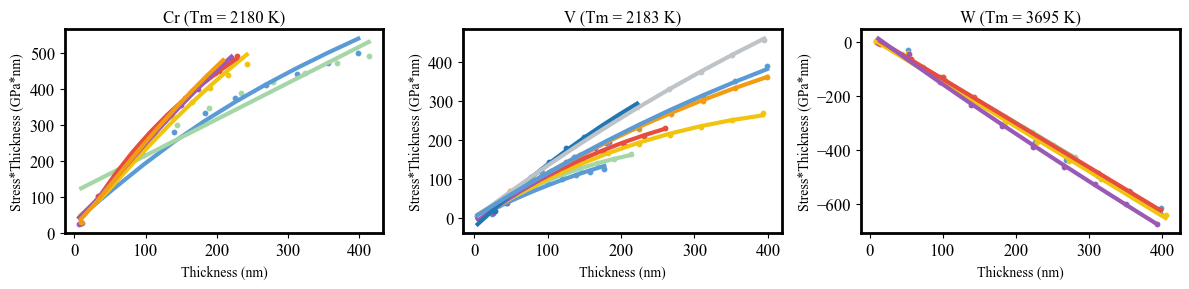

In [9]:
# Plot fitted vs experimental results
melting_vals = params['process_condition']['Melting_T'].unique()
n_plots = len(melting_vals)
n_cols = min(4, n_plots)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
if n_plots == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes.reshape(1, -1)

for i, tm in enumerate(melting_vals):
    r, c = divmod(i, n_cols)
    ax = axes[r, c]
    matching_rows = params['process_condition'][params['process_condition']['Melting_T'] == tm].index.tolist()
    color_id = 0
    for dataset_id in matching_rows:
        mask = fit_data["Index"] == dataset_id + 1
        thickness = fit_data.loc[mask, "thickness"].reset_index(drop=True)
        raw_data = fit_data.loc[mask, "StressThickness"].reset_index(drop=True)
        pred_data = fit_data.loc[mask, "y_pred"].reset_index(drop=True)
        ax.plot(thickness, pred_data, color=COLORS[color_id], linewidth=3)
        ax.scatter(thickness, raw_data, color=COLORS[color_id], s=10)
        color_id = (color_id + 1) % len(COLORS)
    ax.set_title(f"{unique_materials[i]} (Tm = {tm:.0f} K)")
    ax.set_xlabel("Thickness (nm)")
    ax.set_ylabel("Stress*Thickness (GPa*nm)")
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.tick_params(labelsize=12)

for j in range(n_plots, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])
plt.tight_layout()
plt.show()

In [10]:
# Extract and display optimized parameters
with torch.no_grad():
    optimized_scaled = model.x_vector_scaled.cpu().numpy()

para_lb, para_ub = params['para_lb'], params['para_ub']
n_mat_params = len(params['material_cols'])
n_proc_params = len(params['process_cols'])

vector_param = optimized_scaled * (para_ub - para_lb) + para_lb

mat_count = n_materials * n_mat_params
materials_para = vector_param[:mat_count].reshape(n_materials, n_mat_params)

n_datasets = (len(vector_param) - mat_count) // n_proc_params
process_para = vector_param[mat_count:].reshape(n_datasets, n_proc_params)

# Display material parameters
mat_df = pd.DataFrame(materials_para, columns=params['material_cols'],
                       index=unique_materials)
print("Optimized Material Parameters:")
display(mat_df)

# Display process parameters
proc_df = pd.DataFrame(process_para, columns=params['process_cols'],
                        index=experiment_labels)
print("\nOptimized Process Parameters:")
display(proc_df)

Optimized Material Parameters:


,Sigma0,BetaD,Ea,Mfda,Di,A0,B0,l0
Cr,8.929406,0.035247,0.000538,23.596057,0.983448,-1.252807,-3.380610,0.509926
V,19.806898,0.002662,0.000488,0.011656,0.013690,-2.020743,-5.203662,1.233595
W,10.736720,0.045446,0.000494,35.406713,0.499536,-4.030689,-10.901960,0.960843



Optimized Process Parameters:


,SigmaC,K0,alpha1,L0,GrainSize_200
Cr_Su_R0.08_T295_P0.27,0.0005,49.322855,0.000357,0.013508,26.365796
Cr_Su_R0.12_T295_P0.27,0.0005,124.594688,0.054983,19.928310,19.925874
Cr_Su_R0.24_T295_P0.27,0.0005,50.742710,0.078655,5.697427,25.691481
Cr_Su_R0.36_T295_P0.27,0.0005,39.970851,0.044244,2.042761,25.592507
Cr_Su_R0.48_T295_P0.27,0.0005,43.605709,0.057970,6.708187,21.122702
Cr_Su_R0.6_T295_P0.27,0.0005,37.882555,0.057734,6.098135,20.273953
V_Su_R0.02_T295_P0.27,0.0005,2.100492,0.054983,14.513682,25.090409
V_Su_R0.04_T295_P0.27,0.0005,1.829016,0.054983,12.516834,20.900293
V_Su_R0.06_T295_P0.27,0.0005,9.170365,0.054983,13.603951,18.289204
V_Su_R0.08_T295_P0.27,0.0005,-0.950700,0.054983,13.486352,18.196057
